## 1. Imports


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import deeplake
from lib.dataset import peek_labels

print(tf.__version__)


2.15.0


d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\check_latest_version.py:32: UserWarning: A newer version of deeplake (3.8.16) is available. It's recommended that you update to the latest version using `pip install -U deeplake`.
  warnings.warn(


## 2. Load Dataset


In [2]:
ROOT_PATH = "D:/Programming/Projects/Public/plant-lens/ai"
DATASET_DATA_PATH = f"{ROOT_PATH}/data/dataset"

raw_training_dataset = deeplake.load(f'{DATASET_DATA_PATH}/training')
raw_testing_dataset = deeplake.load(f'{DATASET_DATA_PATH}/testing')

raw_training_dataset.summary()
raw_testing_dataset.summary()

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training loaded successfully.

D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing loaded successfully.

Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/training', read_only=True, tensors=['images', 'labels'])

 tensor      htype           shape          dtype  compression
 -------    -------         -------        -------  ------- 
 images      image     (448, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (448, 1)       uint16    None   
Dataset(path='D:/Programming/Projects/Public/plant-lens/ai/data/dataset/testing', read_only=True, tensors=['images', 'labels'])

 tensor      htype           shape          dtype  compression
 -------    -------         -------        -------  ------- 
 images      image     (112, 224, 224, 3)   uint8    jpeg   
 labels   class_label       (112, 1)       uint16    None   


d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\warnings.py:7: UserWarning: Checking out dataset in read only mode as another machine has locked this version for writing.
  warnings.warn(*args, **kwargs)

d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\core\fast_forwarding.py:43: UserWarning: Loading a dataset that was created or updated with a newer version of deeplake. This could lead to corruption or unexpected errors! Dataset version: 3.8.16, current deeplake version: 3.8.14. It's recommended that you update to a version of deeplake >= 3.8.16.
  warnings.warn(

d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-packages\deeplake\util\warnings.py:7: UserWarning: Checking out dataset in read only mode as another machine has locked this version for writing.
  warnings.warn(*args, **kwargs)

d:\Programming\Projects\Public\plant-lens\ai\scripts\maker\.venv\Lib\site-package

In [3]:
data_classes = list(set(sum(raw_training_dataset.labels.data()['text'], [])))
data_classes_count = len(data_classes)
print("Total Number of Classes", data_classes_count)

Total Number of Classes 28


### 2.2 Create Data Pipeline


In [4]:
training_size = int(len(raw_training_dataset.labels) * 0.8)
print("Train Data Size", training_size, "Validation Data Size",
      len(raw_training_dataset.labels) - training_size)

raw_training_dataset = raw_training_dataset.tensorflow()
raw_testing_dataset = raw_testing_dataset.tensorflow()

raw_validation_dataset = raw_training_dataset.skip(training_size)
raw_training_dataset = raw_training_dataset.take(training_size)

Train Data Size 358 Validation Data Size 90


In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

def augment(image):
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_brightness(image, max_delta=0.1)
        image = tf.image.random_contrast(image, lower=0.4, upper=0.8)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.tile(tf.image.rgb_to_grayscale(image), [1, 1, 3])
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_left_right(image)
    if tf.random.uniform((), minval=0, maxval=1) < 0.5:
        image = tf.image.random_flip_up_down(image)

    return image
    

# Define a preprocessing function
def preprocess_image(do_augment=True) :
    def wrapper(args)-> tuple:
      image = augment(args['images']) if do_augment else args['images']
      image = tf.cast(image, tf.float32)
      image = tf.math.divide(image, 255.0)
    
      label = args['labels']
      label = tf.cast(label, tf.int32)
      label = tf.squeeze(label)

      return (image, label)
    return wrapper


training_dataset = raw_training_dataset.map(preprocess_image(), num_parallel_calls=AUTOTUNE)
validation_dataset = raw_validation_dataset.map(preprocess_image(), num_parallel_calls=AUTOTUNE)
testing_dataset = raw_testing_dataset.map(preprocess_image(do_augment=False), num_parallel_calls=AUTOTUNE)

# Shuffle and batch the datasets
BATCH_SIZE = 32
training_dataset = training_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_dataset = validation_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
testing_dataset = testing_dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [23]:
for images, labels in training_dataset.take(1):
    print("Training Batch images shape:", images.shape)
    print("Training Batch labels shape:", labels.shape)

for images, labels in validation_dataset.take(1):
    print("Validation Batch images shape:", images.shape)
    print("Validation Batch labels shape:", labels.shape)

for images, labels in testing_dataset.take(1):
    print("Testing Batch images shape:", images.shape)
    print("Testing Batch labels shape:", labels.shape)

Training Batch images shape: (32, 224, 224, 3)
Training Batch labels shape: (32,)
Testing Batch images shape: (32, 224, 224, 3)
Testing Batch labels shape: (32,)
Validation Batch images shape: (32, 224, 224, 3)
Validation Batch labels shape: (32,)


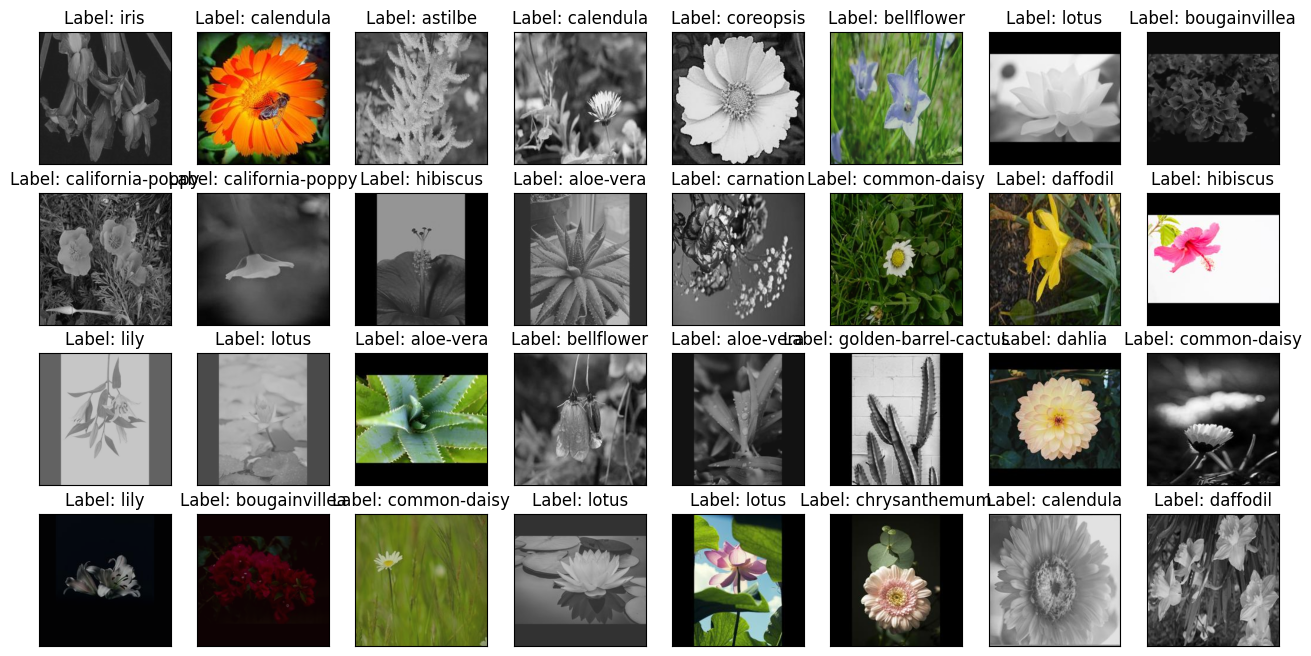

In [24]:
class_names=['aloe-vera', 'astilbe', 'bellflower', 'black-eyed-susan', 'bougainvillea', 'calendula', 'california-poppy', 'carnation', 'chrysanthemum', 'common-daisy', 'coreopsis', 'daffodil', 'dahlia', 'dandelion', 'golden-barrel-cactus', 'hibiscus', 'iris', 'jasmine', 'lavender', 'lily', 'lotus', 'magnolia', 'marigold', 'rose', 'snake-plant', 'sunflower', 'tulip', 'water-lily']

peek_labels(training_dataset, class_names=class_names)

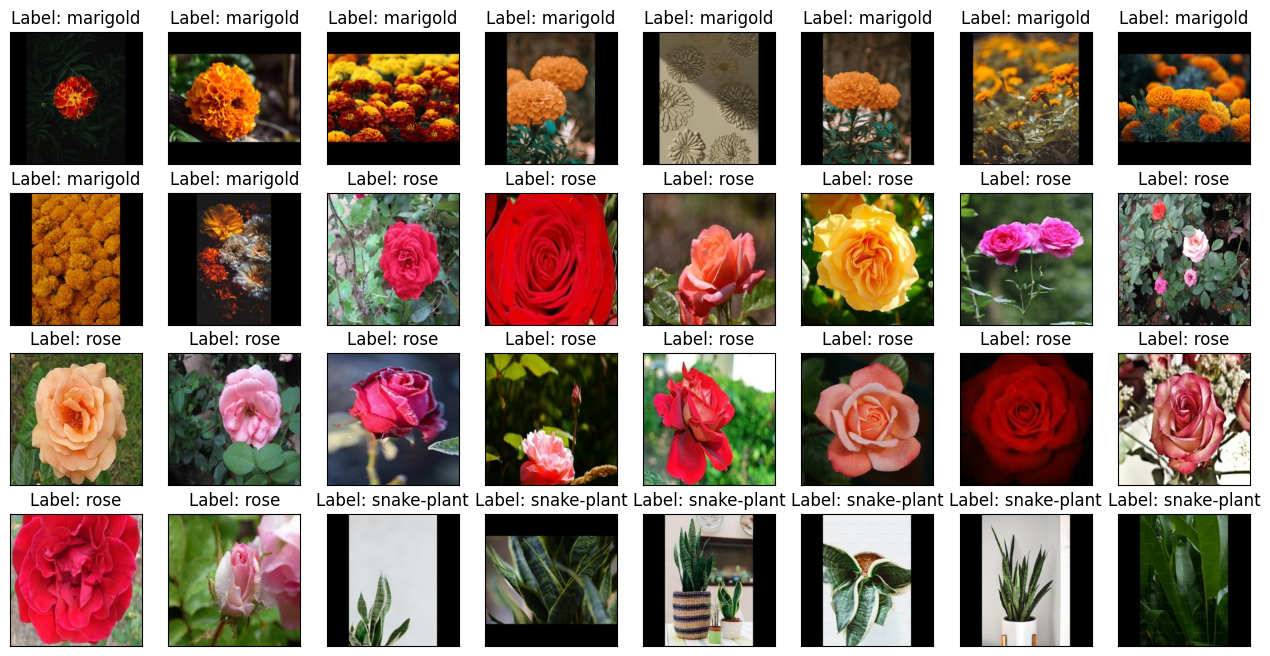

In [25]:
peek_labels(validation_dataset, class_names=class_names)


In [ ]:
peek_labels(testing_dataset, class_names=class_names)


## 3. Build Model


In [35]:
from tensorflow.keras import Model, layers, optimizers, models, callbacks, applications
import tensorflow_hub as hub


def build_model():
    dimensions = 224
    input_layer = layers.Input(shape=(dimensions, dimensions, 3))
    feature_extractor = applications.mobilenet_v2.MobileNetV2(
        input_shape=(dimensions, dimensions, 3),
        include_top=False,
        weights='imagenet'
    )(input_layer)
    feature_extractor.trainable = False
    # feature_extractor = hub.KerasLayer('https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5', trainable=True)(input_layer)
    # flatten_layer = layers.Flatten()(feature_extractor)
    flatten_layer = layers.GlobalAveragePooling2D()(feature_extractor)
    dropout_layer = layers.Dropout(0.5)(flatten_layer)
    hidden_layer = layers.Dense(512, activation='relu')(dropout_layer)
    dropout_layer = layers.Dropout(0.5)(hidden_layer)
    predictions = layers.Dense(
        data_classes_count, activation='softmax')(dropout_layer)
    model = Model(inputs=input_layer, outputs=predictions)

    LEARNING_RATE = 0.0001
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


DEVELOPMENT_MODEL_PATH = f"{ROOT_PATH}/model/develop"
VERSION_TAG = "0.2.0-46"
BUILD_MODEL = True

if BUILD_MODEL:
    model = build_model()
else:
    model = models.load_model(f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.keras')

model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_4  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_8 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 512)               655872    
                                                                 
 dropout_9 (Dropout)         (None, 512)               0   

## 4. Train Model


In [45]:
%%time

EPOCHS = 10
VERSION = "0.3.1"
CHECKPOINT_MODEL_PATH = f"{ROOT_PATH}/model/checkpoint/{VERSION}"

checkpoint_callback = callbacks.ModelCheckpoint(filepath=CHECKPOINT_MODEL_PATH, save_weights_only=True, verbose=1)
# Train the model
history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset, callbacks=[checkpoint_callback])


Epoch 1/10


     12/Unknown - 19s 1s/step - loss: 1.8156 - accuracy: 0.4860
Epoch 1: saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\0.3.1
12/12 [==============================] - 22s 2s/step - loss: 1.8156 - accuracy: 0.4860 - val_loss: 6.3100 - val_accuracy: 0.0000e+00
Epoch 2/10
12/12 [==============================] - ETA: 0s - loss: 1.7049 - accuracy: 0.5000
Epoch 2: saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\0.3.1
12/12 [==============================] - 19s 2s/step - loss: 1.7049 - accuracy: 0.5000 - val_loss: 6.5059 - val_accuracy: 0.0000e+00
Epoch 3/10
12/12 [==============================] - ETA: 0s - loss: 1.5269 - accuracy: 0.5642
Epoch 3: saving model to D:/Programming/Projects/Public/plant-lens/ai/model/checkpoint\0.3.1
12/12 [==============================] - 19s 1s/step - loss: 1.5269 - accuracy: 0.5642 - val_loss: 6.7825 - val_accuracy: 0.0000e+00
Epoch 4/10
12/12 [==============================] - ETA: 0s - loss: 1.

### 4.2 Training Result



initial | Training loss: 1.8156 | Validation Loss: 6.3100 || Training Accuracy: 48.60 % | Validation Accuracy: 0.00 %
 latest | Training loss: 0.8214 | Validation Loss: 8.2722 || Training Accuracy: 75.70 % | Validation Accuracy: 0.00 %


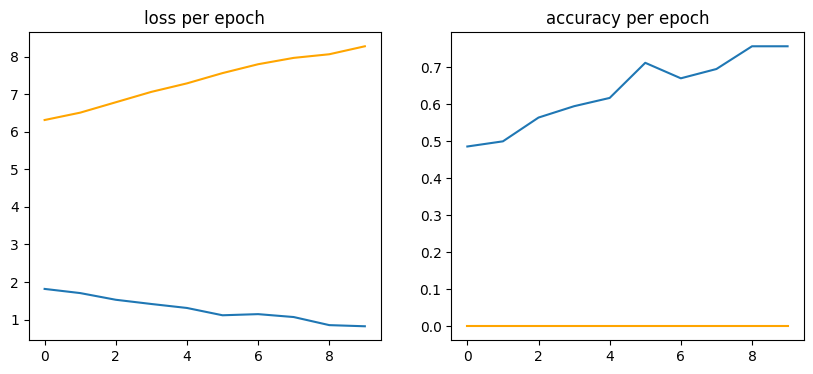

In [46]:
# access metrics from training history
print("\ninitial | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][0], history.history["val_loss"][0], history.history["accuracy"][0] * 100, history.history["val_accuracy"][0] * 100))
print(" latest | Training loss: {:.4f} | Validation Loss: {:.4f} || Training Accuracy: {:.2f} % | Validation Accuracy: {:.2f} %".format(
    history.history["loss"][-1], history.history["val_loss"][-1], history.history["accuracy"][-1] * 100, history.history["val_accuracy"][-1] * 100))

fig, axis = plt.subplots(1, 2, figsize=(10, 4))
# plot loss
axis[0].plot(history.history["loss"])
axis[0].plot(history.history["val_loss"], color='orange')
axis[0].set_title("loss per epoch")
# plot accuracy
axis[1].plot(history.history["accuracy"])
axis[1].plot(history.history["val_accuracy"], color='orange')
axis[1].set_title("accuracy per epoch")
plt.show()

## 5. Test Model


In [47]:
# Evaluate the model
test_loss, test_acc = model.evaluate(testing_dataset)

print('Test loss:', test_loss, 'Test accuracy:', test_acc)

4/4 [==============================] - 2s 407ms/step - loss: 3.4071 - accuracy: 0.3125
Test loss: 3.4070658683776855 Test accuracy: 0.3125


## 6. Visualize Result


4/4 [==============================] - 2s 420ms/step


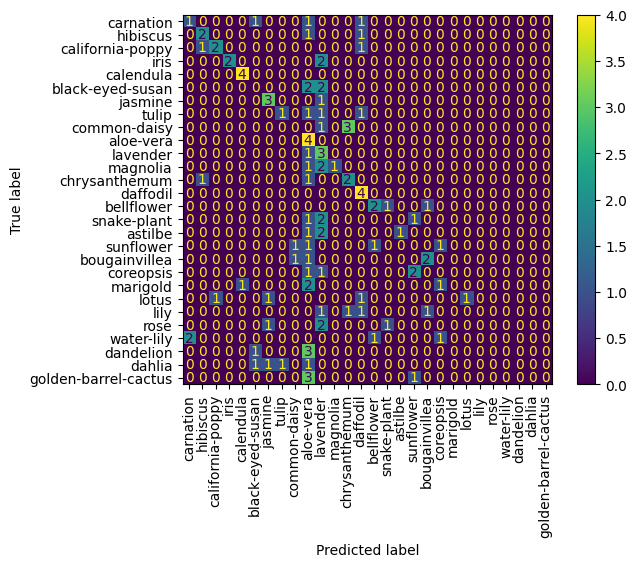

In [48]:
from sklearn import metrics

true_labels = []
for _, labels in testing_dataset:
    true_labels.extend(labels.numpy())

predictions = model.predict(testing_dataset)
predicted_labels = tf.math.argmax(predictions, axis=1).numpy()

confusion_matrix = metrics.confusion_matrix(true_labels, predicted_labels)
cm_display = metrics.ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix, display_labels=data_classes)

cm_display.plot()

# Rotate x-axis labels by 15 degrees
plt.xticks(rotation=90)
plt.show()

## 7. Save Model


In [ ]:
VERSION_TAG = input("Enter Version Tag (e.g 0.0.0):") + \
    f"-{int(test_acc * 100)}" if BUILD_MODEL else VERSION_TAG  # "0.0.0"

models.save_model(
    model, f'{DEVELOPMENT_MODEL_PATH}/v{VERSION_TAG}.h5', save_format="h5")